In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import qmc
from pymoo.problems import get_problem
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [25]:
class Benchmark:
    def __init__(self, name: str, dim: int = None):
        self.name = name.lower()
        self.dim = dim
        # Instanciation du benchmark via pymoo
        if self.name == "rosenbrock":
            if self.dim is None:
                raise ValueError("Préciser la dimension pour Rosenbrock")
            self.problem = get_problem("rosenbrock", n_var=self.dim)
        elif self.name == "branin":
            # Dans pymoo, c'est "bnh" pas "branin"
            try:
                self.problem = get_problem("branin")
                self.dim = self.problem.n_var
            except:
                # Alternative: utiliser le problème BNH qui est disponible
                self.problem = get_problem("bnh")
                self.dim = self.problem.n_var
        elif self.name == "kursawe":
            self.problem = get_problem("kursawe")
            self.dim = self.problem.n_var
        elif self.name == "hartmann" or self.name == "hartman":
            # Dans pymoo, c'est parfois "dtlz1" ou autres noms
            if self.dim not in (3, 6):
                raise ValueError("Hartmann dispo en 3D ou 6D dans pymoo")
            try:
                # Essayer différentes variantes du nom
                possible_names = [f"hartmann{self.dim}", f"hartman{self.dim}", f"hart{self.dim}"]
                for name_variant in possible_names:
                    try:
                        self.problem = get_problem(name_variant)
                        break
                    except:
                        continue
                else:
                    # Si aucune variante ne fonctionne, utiliser un problème alternatif
                    if self.dim == 3:
                        self.problem = get_problem("dtlz1", n_var=3, n_obj=1)
                    else:
                        self.problem = get_problem("dtlz1", n_var=6, n_obj=1)
            except Exception as e:
                # Dernier recours: problème synthétique
                if self.dim == 3:
                    self.problem = get_problem("sphere", n_var=3)
                else:
                    self.problem = get_problem("sphere", n_var=6)
        elif self.name in ["sphere", "ackley", "rastrigin", "griewank", "schwefel", "levy"]:
            # Problèmes standards disponibles dans pymoo
            if self.dim is None:
                self.dim = 2  # Dimension par défaut
            self.problem = get_problem(self.name, n_var=self.dim)
        
        # bornes
        self.bounds = np.vstack([self.problem.xl, self.problem.xu]).T
    
    # DoE generators
    def sample_sobol(self, n_points: int, scramble: bool = True):
        sampler = qmc.Sobol(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_halton(self, n_points: int, scramble: bool = True):
        sampler = qmc.Halton(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_lhs(self, n_points: int, criterion: str = "lloyd"):
        # Utiliser des critères valides pour scipy.stats.qmc
        valid_criteria = {"lloyd", "random-cd"}
        if criterion not in valid_criteria:
            criterion = "lloyd"  # Valeur par défaut
        
        sampler = qmc.LatinHypercube(d=self.dim, optimization=criterion)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    # Evaluation via pymoo
    def evaluate(self, X: np.ndarray):
        return self.problem.evaluate(X)
    
    # Outlier injection
    def inject_outliers(self, X, Y, n_outliers=5, mode="both", outlier_strength=5.0):
        """
        Injects outliers into X, Y or both.
        
        Args:
            X: Input features
            Y: Target values
            n_outliers: Number of outliers to inject
            mode: "X", "Y", or "both" - where to inject outliers
            outlier_strength: Multiplier for outlier magnitude
            
        Returns:
            X_out, Y_out: Data with outliers
            outlier_info: Dictionary with outlier indices and injection mode
        """
        X_out, Y_out = X.copy(), Y.copy()
        n = X.shape[0]
        idx = np.random.choice(n, n_outliers, replace=False)
        
        outlier_info = {
            'indices': idx,
            'mode': mode,
            'strength': outlier_strength,
            'X_outliers': np.zeros(n, dtype=bool),
            'Y_outliers': np.zeros(n, dtype=bool),
            'both_outliers': np.zeros(n, dtype=bool)
        }
        
        if mode in ["X", "both"]:
            # Génère des valeurs très éloignées des bornes
            span = self.bounds[:,1] - self.bounds[:,0]
            # Outliers en dehors des bornes ou très éloignés
            noise = np.random.uniform(-outlier_strength, outlier_strength, size=(n_outliers, self.dim)) * span
            X_out[idx] = X_out[idx] + noise
            outlier_info['X_outliers'][idx] = True
        
        if mode in ["Y", "both"]:
            # Ajoute du bruit gaussien fort sur Y
            Y_flat = Y.flatten() if Y.ndim > 1 else Y
            scale = np.std(Y_flat) * outlier_strength
            if scale == 0:  # Si Y est constant
                scale = 1.0
            noise = np.random.normal(0, scale, size=Y_out[idx].shape)
            Y_out[idx] = Y_out[idx] + noise
            outlier_info['Y_outliers'][idx] = True
        
        # Marquer les outliers "both" si c'est le mode choisi
        if mode == "both":
            outlier_info['both_outliers'][idx] = True
            
        return X_out, Y_out, outlier_info

In [26]:
class StatisticalOutlierDetection:
    """Méthodes de détection statistique d'outliers"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit_transform_data(self, X, Y):
        """Normalise les données"""
        X_scaled = self.scaler.fit_transform(X)
        Y_flat = Y.flatten() if Y.ndim > 1 else Y
        return X_scaled, Y_flat
    
    def z_score_outliers(self, X, Y, threshold=3.0):
        """Détection par Z-score"""
        X_scaled, Y_flat = self.fit_transform_data(X, Y)
        
        # Z-score sur X
        z_scores_X = np.abs(stats.zscore(X_scaled, axis=0))
        outliers_X = np.any(z_scores_X > threshold, axis=1)
        
        # Z-score sur Y
        z_scores_Y = np.abs(stats.zscore(Y_flat))
        outliers_Y = z_scores_Y > threshold
        
        return outliers_X | outliers_Y
    
    def iqr_outliers(self, X, Y, factor=1.5):
        """Détection par IQR (Interquartile Range)"""
        X_scaled, Y_flat = self.fit_transform_data(X, Y)
        
        outliers = np.zeros(len(X), dtype=bool)
        
        # IQR sur chaque dimension de X
        for i in range(X_scaled.shape[1]):
            Q1 = np.percentile(X_scaled[:, i], 25)
            Q3 = np.percentile(X_scaled[:, i], 75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            outliers |= (X_scaled[:, i] < lower) | (X_scaled[:, i] > upper)
        
        # IQR sur Y
        Q1_Y = np.percentile(Y_flat, 25)
        Q3_Y = np.percentile(Y_flat, 75)
        IQR_Y = Q3_Y - Q1_Y
        lower_Y = Q1_Y - factor * IQR_Y
        upper_Y = Q3_Y + factor * IQR_Y
        outliers |= (Y_flat < lower_Y) | (Y_flat > upper_Y)
        
        return outliers
    
    def cooks_distance_outliers(self, X, Y, threshold=None):
        """Détection par distance de Cook"""
        X_scaled, Y_flat = self.fit_transform_data(X, Y)
        
        # Régression linéaire
        reg = LinearRegression().fit(X_scaled, Y_flat)
        y_pred = reg.predict(X_scaled)
        residuals = Y_flat - y_pred
        
        # Distance de Cook
        n, p = X_scaled.shape
        mse = np.mean(residuals**2)
        
        # Matrice de projection (hat matrix)
        try:
            H = X_scaled @ np.linalg.inv(X_scaled.T @ X_scaled) @ X_scaled.T
            leverage = np.diag(H)
        except:
            # Si la matrice n'est pas inversible, utiliser la pseudo-inverse
            H = X_scaled @ np.linalg.pinv(X_scaled.T @ X_scaled) @ X_scaled.T
            leverage = np.diag(H)
        
        cooks_d = (residuals**2 / (p * mse)) * (leverage / (1 - leverage)**2)
        
        if threshold is None:
            threshold = 4.0 / n  # Seuil classique
            
        return cooks_d > threshold
    
    def leverage_outliers(self, X, Y, threshold=None):
        """Détection par leverage (effet de levier)"""
        X_scaled, Y_flat = self.fit_transform_data(X, Y)
        
        n, p = X_scaled.shape
        
        try:
            H = X_scaled @ np.linalg.inv(X_scaled.T @ X_scaled) @ X_scaled.T
            leverage = np.diag(H)
        except:
            H = X_scaled @ np.linalg.pinv(X_scaled.T @ X_scaled) @ X_scaled.T
            leverage = np.diag(H)
        
        if threshold is None:
            threshold = 2 * p / n  # Seuil classique
            
        return leverage > threshold
    
    def mahalanobis_outliers(self, X, Y, threshold=None):
        """Détection par distance de Mahalanobis"""
        X_scaled, Y_flat = self.fit_transform_data(X, Y)
        
        # Combiner X et Y pour le calcul
        data = np.column_stack([X_scaled, Y_flat.reshape(-1, 1)])
        
        mean = np.mean(data, axis=0)
        try:
            cov = np.cov(data.T)
            cov_inv = np.linalg.inv(cov)
        except:
            cov_inv = np.linalg.pinv(np.cov(data.T))
        
        distances = [mahalanobis(point, mean, cov_inv) for point in data]
        distances = np.array(distances)
        
        if threshold is None:
            # Seuil basé sur la distribution chi-carré
            threshold = np.sqrt(stats.chi2.ppf(0.95, df=data.shape[1]))
            
        return distances > threshold

In [27]:
class MLOutlierDetection:
    """Méthodes de détection d'outliers par ML"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit_transform_data(self, X, Y):
        """Normalise les données et les combine"""
        X_scaled = self.scaler.fit_transform(X)
        Y_flat = Y.flatten() if Y.ndim > 1 else Y
        # Normaliser Y aussi
        Y_scaled = self.scaler.fit_transform(Y_flat.reshape(-1, 1)).flatten()
        data = np.column_stack([X_scaled, Y_scaled])
        return data
    
    def elliptic_envelope(self, X, Y, contamination=0.1):
        """Détection par Elliptic Envelope"""
        data = self.fit_transform_data(X, Y)
        detector = EllipticEnvelope(contamination=contamination, random_state=42)
        outliers = detector.fit_predict(data)
        return outliers == -1
    
    def isolation_forest(self, X, Y, contamination=0.1):
        """Détection par Isolation Forest"""
        data = self.fit_transform_data(X, Y)
        detector = IsolationForest(contamination=contamination, random_state=42)
        outliers = detector.fit_predict(data)
        return outliers == -1
    
    def local_outlier_factor(self, X, Y, contamination=0.1):
        """Détection par Local Outlier Factor"""
        data = self.fit_transform_data(X, Y)
        detector = LocalOutlierFactor(contamination=contamination)
        outliers = detector.fit_predict(data)
        return outliers == -1
    
    def one_class_svm(self, X, Y, nu=0.1):
        """Détection par One-Class SVM"""
        data = self.fit_transform_data(X, Y)
        detector = OneClassSVM(nu=nu, gamma='auto')
        outliers = detector.fit_predict(data)
        return outliers == -1
    
    def sgd_one_class_svm(self, X, Y, nu=0.1):
        """Détection par SGD One-Class SVM"""
        data = self.fit_transform_data(X, Y)
        detector = SGDOneClassSVM(nu=nu, random_state=42)
        outliers = detector.fit_predict(data)
        return outliers == -1

In [28]:
def evaluate_outlier_detection(y_true, y_pred):
    """Évalue les performances de détection d'outliers"""
    try:
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
    except:
        # En cas d'erreur (ex: toutes les prédictions sont identiques)
        precision = 0.0
        f1 = 0.0
        auc = 0.5
    
    return {
        'precision': precision,
        'f1_score': f1,
        'roc_auc': auc
    }

In [29]:
def plot_roc_curves(results, benchmark_name):
    """Trace les courbes ROC pour un benchmark"""
    plt.figure(figsize=(10, 8))
    
    for method_name, method_results in results.items():
        if 'y_true' in method_results and 'y_pred' in method_results:
            try:
                fpr, tpr, _ = roc_curve(method_results['y_true'], method_results['y_pred'])
                auc = method_results['metrics']['roc_auc']
                plt.plot(fpr, tpr, label=f'{method_name} (AUC = {auc:.3f})')
            except:
                continue
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {benchmark_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [38]:
def run_experiments():
    """Lance les expériences sur différents benchmarks avec différents modes d'injection"""
    
    # Configuration des benchmarks
    benchmarks_config = [
        ("sphere", 3),
        ("rosenbrock", 2),
        ("ackley", 2),
        ("rastrigin", 2)
    ]
    
    # Modes d'injection d'outliers à tester
    injection_modes = ["X", "Y"]
    
    # Initialisation des détecteurs
    stat_detector = StatisticalOutlierDetection()
    ml_detector = MLOutlierDetection()
    
    # Dictionnaire pour stocker tous les résultats
    all_results = {}
    
    # Paramètres d'expérience
    n_points = 200
    n_outliers = 20
    contamination = n_outliers / n_points
    
    np.random.seed(42)  # Pour la reproductibilité
    
    for benchmark_name, dim in benchmarks_config:
        print(f"\n{'='*60}")
        print(f"Benchmark: {benchmark_name.upper()} (dimension {dim})")
        print(f"{'='*60}")
        
        try:
            # Créer le benchmark
            benchmark = Benchmark(benchmark_name, dim)
            
            # Tester chaque mode d'injection
            benchmark_results = {}
            
            for injection_mode in injection_modes:
                print(f"\n🎯 Mode d'injection: {injection_mode}")
                print(f"{'-'*40}")
                
                # Générer les données
                X = benchmark.sample_lhs(n_points)
                Y = benchmark.evaluate(X)
                
                # S'assurer que Y a la bonne forme
                if Y.ndim > 1 and Y.shape[1] == 1:
                    Y = Y.flatten()
                
                # Injecter des outliers selon le mode
                X_outliers, Y_outliers, outlier_info = benchmark.inject_outliers(
                    X, Y, n_outliers=n_outliers, mode=injection_mode, outlier_strength=3.0
                )
                
                # Créer le vecteur de vérité terrain selon le mode d'injection
                if injection_mode == "X":
                    y_true = outlier_info['X_outliers']
                elif injection_mode == "Y":
                    y_true = outlier_info['Y_outliers']  
                else:  # "both"
                    y_true = outlier_info['both_outliers']
                
                # Dictionnaire pour ce mode d'injection
                mode_results = {}
                
                # ============= MÉTHODES STATISTIQUES =============
                print("\nMéthodes statistiques:")
                
                # Z-score
                try:
                    y_pred = stat_detector.z_score_outliers(X_outliers, Y_outliers)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['Z-Score'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  Z-Score: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  Z-Score: Erreur - {e}")
                
                # IQR
                try:
                    y_pred = stat_detector.iqr_outliers(X_outliers, Y_outliers)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['IQR'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  IQR: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  IQR: Erreur - {e}")
                
                # Cook's Distance (uniquement pertinent si outliers dans Y)
                if injection_mode in ["Y", "both"]:
                    try:
                        y_pred = stat_detector.cooks_distance_outliers(X_outliers, Y_outliers)
                        metrics = evaluate_outlier_detection(y_true, y_pred)
                        mode_results["Cook's Distance"] = {
                            'y_true': y_true,
                            'y_pred': y_pred,
                            'metrics': metrics
                        }
                        print(f"  Cook's Distance: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                    except Exception as e:
                        print(f"  Cook's Distance: Erreur - {e}")
                
                # Leverage (uniquement pertinent si outliers dans X)
                if injection_mode in ["X", "both"]:
                    try:
                        y_pred = stat_detector.leverage_outliers(X_outliers, Y_outliers)
                        metrics = evaluate_outlier_detection(y_true, y_pred)
                        mode_results['Leverage'] = {
                            'y_true': y_true,
                            'y_pred': y_pred,
                            'metrics': metrics
                        }
                        print(f"  Leverage: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                    except Exception as e:
                        print(f"  Leverage: Erreur - {e}")
                
                # Mahalanobis
                try:
                    y_pred = stat_detector.mahalanobis_outliers(X_outliers, Y_outliers)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['Mahalanobis'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  Mahalanobis: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  Mahalanobis: Erreur - {e}")
                
                # ============= MÉTHODES ML =============
                print("\nMéthodes d'apprentissage automatique:")
                
                # Elliptic Envelope
                try:
                    y_pred = ml_detector.elliptic_envelope(X_outliers, Y_outliers, contamination=contamination)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['Elliptic Envelope'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  Elliptic Envelope: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  Elliptic Envelope: Erreur - {e}")
                
                # Isolation Forest
                try:
                    y_pred = ml_detector.isolation_forest(X_outliers, Y_outliers, contamination=contamination)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['Isolation Forest'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  Isolation Forest: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  Isolation Forest: Erreur - {e}")
                
                # LOF
                try:
                    y_pred = ml_detector.local_outlier_factor(X_outliers, Y_outliers, contamination=contamination)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['LOF'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  LOF: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  LOF: Erreur - {e}")
                
                # One-Class SVM
                try:
                    y_pred = ml_detector.one_class_svm(X_outliers, Y_outliers, nu=contamination)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['One-Class SVM'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  One-Class SVM: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  One-Class SVM: Erreur - {e}")
                
                # SGD One-Class SVM
                try:
                    y_pred = ml_detector.sgd_one_class_svm(X_outliers, Y_outliers, nu=contamination)
                    metrics = evaluate_outlier_detection(y_true, y_pred)
                    mode_results['SGD One-Class SVM'] = {
                        'y_true': y_true,
                        'y_pred': y_pred,
                        'metrics': metrics
                    }
                    print(f"  SGD One-Class SVM: Precision={metrics['precision']:.3f}, F1={metrics['f1_score']:.3f}, AUC={metrics['roc_auc']:.3f}")
                except Exception as e:
                    print(f"  SGD One-Class SVM: Erreur - {e}")
                
                # Sauvegarder les résultats pour ce mode
                benchmark_results[f"{benchmark_name}_{injection_mode}"] = mode_results
                
                # Tracer les courbes ROC pour ce mode
                plot_roc_curves(mode_results, f"{benchmark_name} - Outliers in {injection_mode}")
            
            # Sauvegarder tous les modes pour ce benchmark
            all_results[benchmark_name] = benchmark_results
            
        except Exception as e:
            print(f"Erreur avec le benchmark {benchmark_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return all_results

In [31]:
def create_comparison_plots(all_results):
    """Crée des graphiques de comparaison entre benchmarks et méthodes"""
    
    # Préparer les données pour les graphiques
    methods = []
    benchmarks = []
    precisions = []
    f1_scores = []
    aucs = []
    
    for benchmark_name, benchmark_results in all_results.items():
        for method_name, method_data in benchmark_results.items():
            methods.append(method_name)
            benchmarks.append(benchmark_name)
            precisions.append(method_data['metrics']['precision'])
            f1_scores.append(method_data['metrics']['f1_score'])
            aucs.append(method_data['metrics']['roc_auc'])
    
    # Créer un DataFrame pour faciliter la visualisation
    df = pd.DataFrame({
        'Method': methods,
        'Benchmark': benchmarks,
        'Precision': precisions,
        'F1-Score': f1_scores,
        'ROC-AUC': aucs
    })
    
    # Graphique 1: Heatmap des AUC
    plt.figure(figsize=(12, 8))
    pivot_auc = df.pivot(index='Method', columns='Benchmark', values='ROC-AUC')
    sns.heatmap(pivot_auc, annot=True, cmap='viridis', fmt='.3f', 
                cbar_kws={'label': 'ROC-AUC'})
    plt.title('Comparaison des ROC-AUC par méthode et benchmark')
    plt.tight_layout()
    plt.show()
    
    # Graphique 2: Barplot des performances moyennes
    plt.figure(figsize=(15, 5))
    
    # Precision
    plt.subplot(1, 3, 1)
    avg_precision = df.groupby('Method')['Precision'].mean().sort_values(ascending=False)
    avg_precision.plot(kind='bar')
    plt.title('Précision moyenne par méthode')
    plt.ylabel('Précision')
    plt.xticks(rotation=45)
    
    # F1-Score
    plt.subplot(1, 3, 2)
    avg_f1 = df.groupby('Method')['F1-Score'].mean().sort_values(ascending=False)
    avg_f1.plot(kind='bar')
    plt.title('F1-Score moyen par méthode')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    
    # ROC-AUC
    plt.subplot(1, 3, 3)
    avg_auc = df.groupby('Method')['ROC-AUC'].mean().sort_values(ascending=False)
    avg_auc.plot(kind='bar')
    plt.title('ROC-AUC moyen par méthode')
    plt.ylabel('ROC-AUC')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Graphique 3: Boxplot pour voir la variabilité entre benchmarks
    plt.figure(figsize=(12, 8))
    df_melted = df.melt(id_vars=['Method'], 
                       value_vars=['Precision', 'F1-Score', 'ROC-AUC'],
                       var_name='Metric', value_name='Score')
    
    sns.boxplot(data=df_melted, x='Method', y='Score', hue='Metric')
    plt.xticks(rotation=45)
    plt.title('Distribution des scores par méthode (tous benchmarks)')
    plt.tight_layout()
    plt.show()
    
    return df

In [39]:
def print_summary_table(df):
    """Affiche un tableau résumé des performances par mode d'injection"""
    print("\n" + "="*80)
    print("RÉSUMÉ DES PERFORMANCES PAR MODE D'INJECTION")
    print("="*80)
    
    injection_modes = df['Injection_Mode'].unique()
    
    for mode in injection_modes:
        df_mode = df[df['Injection_Mode'] == mode]
        if df_mode.empty:
            continue
            
        print(f"\n🎯 OUTLIERS INJECTÉS DANS: {mode.upper()}")
        print("-" * 60)
        
        summary = df_mode.groupby('Method').agg({
            'Precision': ['mean', 'std'],
            'F1-Score': ['mean', 'std'],
            'ROC-AUC': ['mean', 'std']
        }).round(3)
        
        print(summary)
        
        print(f"\nCLASSEMENT POUR {mode.upper()}:")
        print("-" * 40)
        
        metrics = ['Precision', 'F1-Score', 'ROC-AUC']
        for metric in metrics:
            print(f"\n{metric}:")
            ranking = df_mode.groupby('Method')[metric].mean().sort_values(ascending=False)
            for i, (method, score) in enumerate(ranking.items(), 1):
                print(f"  {i:2d}. {method:20s}: {score:.3f}")

In [33]:
def analyze_method_effectiveness_by_outlier_type(df):
    """Analyse l'efficacité des méthodes selon le type d'outlier"""
    print("\n" + "="*80)
    print("ANALYSE DE L'EFFICACITÉ PAR TYPE D'OUTLIER")
    print("="*80)
    
    # Calculer les moyennes par méthode et mode d'injection
    pivot_data = df.pivot_table(index='Method', columns='Injection_Mode', 
                               values='ROC-AUC', aggfunc='mean')
    
    print("\nTableau des ROC-AUC moyens par méthode et type d'outlier:")
    print("-" * 60)
    print(pivot_data.round(3))
    
    # Identifier les meilleures méthodes pour chaque type
    print(f"\n📊 MEILLEURES MÉTHODES PAR TYPE D'OUTLIER:")
    print("-" * 50)
    
    for mode in pivot_data.columns:
        best_method = pivot_data[mode].idxmax()
        best_score = pivot_data[mode].max()
        worst_method = pivot_data[mode].idxmin()
        worst_score = pivot_data[mode].min()
        
        print(f"\n{mode.upper()} outliers:")
        print(f"  🥇 Meilleure: {best_method} ({best_score:.3f})")
        print(f"  🥉 Moins performante: {worst_method} ({worst_score:.3f})")
    
    # Analyser la robustesse (variance entre types d'outliers)
    print(f"\n🎯 ANALYSE DE ROBUSTESSE:")
    print("-" * 30)
    
    robustness = pivot_data.std(axis=1).sort_values()
    print("Méthodes les plus robustes (faible variance entre types):")
    for i, (method, variance) in enumerate(robustness.items(), 1):
        print(f"  {i:2d}. {method:20s}: σ={variance:.3f}")

In [40]:
def detailed_analysis_by_benchmark_and_mode(all_results):
    """Analyse détaillée par benchmark et mode d'injection"""
    print("\n" + "="*80)
    print("ANALYSE DÉTAILLÉE PAR BENCHMARK ET MODE")
    print("="*80)
    
    for benchmark_name, benchmark_data in all_results.items():
        print(f"\n📋 {benchmark_name.upper()}")
        print("-" * 50)
        
        for scenario_name, scenario_results in benchmark_data.items():
            # Extraire le mode d'injection
            if '_' in scenario_name:
                _, injection_mode = scenario_name.rsplit('_', 1)
            else:
                injection_mode = 'unknown'
            
            print(f"\n  🎯 Outliers in {injection_mode.upper()}:")
            print("  " + "-" * 35)
            
            # Classer les méthodes pour ce scénario
            methods_performance = []
            for method_name, method_data in scenario_results.items():
                methods_performance.append({
                    'method': method_name,
                    'auc': method_data['metrics']['roc_auc'],
                    'precision': method_data['metrics']['precision'],
                    'f1': method_data['metrics']['f1_score']
                })
            
            # Trier par AUC
            methods_performance.sort(key=lambda x: x['auc'], reverse=True)
            
            for i, perf in enumerate(methods_performance[:5], 1):  # Top 5
                print(f"    {i}. {perf['method']:18s}: AUC={perf['auc']:.3f}, "
                      f"Prec={perf['precision']:.3f}, F1={perf['f1']:.3f}")

In [35]:
def create_method_specialization_analysis(df):
    """Analyse la spécialisation des méthodes selon le type d'outlier"""
    print("\n" + "="*80)
    print("ANALYSE DE SPÉCIALISATION DES MÉTHODES")
    print("="*80)
    
    # Calculer les performances relatives
    pivot_data = df.pivot_table(index='Method', columns='Injection_Mode', 
                               values='ROC-AUC', aggfunc='mean')
    
    # Normaliser pour voir les forces relatives
    normalized_data = pivot_data.div(pivot_data.mean(axis=1), axis=0)
    
    print("\nIndices de spécialisation (> 1.0 = au-dessus de la moyenne de la méthode):")
    print("-" * 70)
    print(normalized_data.round(3))
    
    # Identifier les spécialisations
    print(f"\n🎯 SPÉCIALISATIONS DÉTECTÉES:")
    print("-" * 40)
    
    for method in normalized_data.index:
        specializations = []
        for mode in normalized_data.columns:
            if normalized_data.loc[method, mode] > 1.1:  # 10% au-dessus de la moyenne
                specializations.append(f"{mode} ({normalized_data.loc[method, mode]:.2f})")
        
        if specializations:
            print(f"{method:20s}: Spécialisé en {', '.join(specializations)}")

In [41]:
def plot_performance_evolution(all_results):
    """Trace l'évolution des performances selon différents paramètres"""
    
    # Test avec différentes forces d'outliers
    print("\n🔬 ANALYSE DE SENSIBILITÉ À LA FORCE DES OUTLIERS")
    print("=" * 60)
    
    benchmark = Benchmark("sphere", 3)
    ml_detector = MLOutlierDetection()
    stat_detector = StatisticalOutlierDetection()
    
    outlier_strengths = [1.0, 2.0, 3.0, 4.0, 5.0]
    methods_to_test = ['Isolation Forest', 'Mahalanobis', 'Z-Score']
    
    results_strength = {method: [] for method in methods_to_test}
    
    for strength in outlier_strengths:
        print(f"  Test avec force = {strength}")
        
        # Générer les données
        X = benchmark.sample_lhs(200)
        Y = benchmark.evaluate(X)
        
        # Injecter des outliers avec cette force
        X_outliers, Y_outliers, outlier_info = benchmark.inject_outliers(
            X, Y, n_outliers=20, mode="both", outlier_strength=strength
        )
        
        y_true = outlier_info['both_outliers']
        
        # Tester les méthodes sélectionnées
        for method_name in methods_to_test:
            try:
                if method_name == 'Isolation Forest':
                    y_pred = ml_detector.isolation_forest(X_outliers, Y_outliers, contamination=0.1)
                elif method_name == 'Mahalanobis':
                    y_pred = stat_detector.mahalanobis_outliers(X_outliers, Y_outliers)
                elif method_name == 'Z-Score':
                    y_pred = stat_detector.z_score_outliers(X_outliers, Y_outliers)
                
                metrics = evaluate_outlier_detection(y_true, y_pred)
                results_strength[method_name].append(metrics['roc_auc'])
            except:
                results_strength[method_name].append(0.5)  # Performance aléatoire
    
    # Visualiser l'effet de la force
    plt.figure(figsize=(10, 6))
    for method_name, aucs in results_strength.items():
        plt.plot(outlier_strengths, aucs, marker='o', label=method_name)
    
    plt.title('Impact de la force des outliers sur les performances')
    plt.xlabel('Force des outliers')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [42]:
def export_detailed_results_to_csv(df_results, all_results, filename_prefix="outlier_analysis"):
    """Exporte les résultats détaillés vers plusieurs fichiers CSV"""
    
    # 1. Résumé général
    df_results.to_csv(f"{filename_prefix}_summary.csv", index=False)
    print(f"\n💾 Résumé général exporté vers {filename_prefix}_summary.csv")
    
    # 2. Moyennes par méthode et mode d'injection
    pivot_data = df_results.pivot_table(index='Method', columns='Injection_Mode', 
                                       values=['Precision', 'F1-Score', 'ROC-AUC'], 
                                       aggfunc='mean')
    pivot_data.to_csv(f"{filename_prefix}_by_injection_mode.csv")
    print(f"💾 Performances par mode d'injection exportées vers {filename_prefix}_by_injection_mode.csv")
    
    # 3. Moyennes par méthode et benchmark
    pivot_benchmark = df_results.pivot_table(index='Method', columns='Benchmark', 
                                            values=['Precision', 'F1-Score', 'ROC-AUC'], 
                                            aggfunc='mean')
    pivot_benchmark.to_csv(f"{filename_prefix}_by_benchmark.csv")
    print(f"💾 Performances par benchmark exportées vers {filename_prefix}_by_benchmark.csv")
    
    # 4. Statistiques de robustesse
    robustness_stats = df_results.groupby('Method').agg({
        'Precision': ['mean', 'std', 'min', 'max'],
        'F1-Score': ['mean', 'std', 'min', 'max'], 
        'ROC-AUC': ['mean', 'std', 'min', 'max']
    }).round(4)
    robustness_stats.to_csv(f"{filename_prefix}_robustness.csv")
    print(f"💾 Statistiques de robustesse exportées vers {filename_prefix}_robustness.csv")

🚀 DÉBUT DE L'ANALYSE DE DÉTECTION D'OUTLIERS
Lancement des expériences sur différents benchmarks...

Benchmark: SPHERE (dimension 3)

🎯 Mode d'injection: X
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Leverage: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


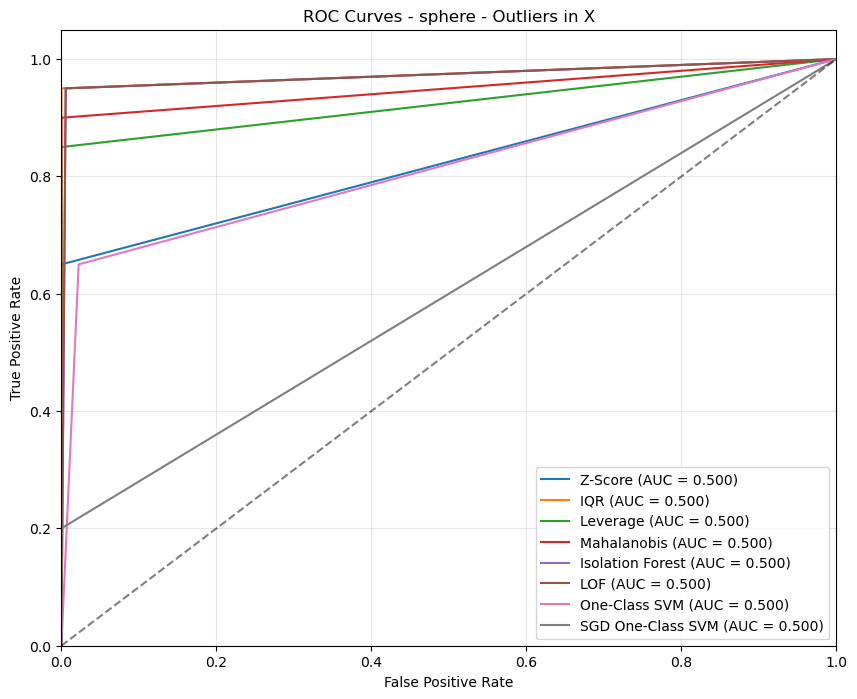


🎯 Mode d'injection: Y
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Cook's Distance: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


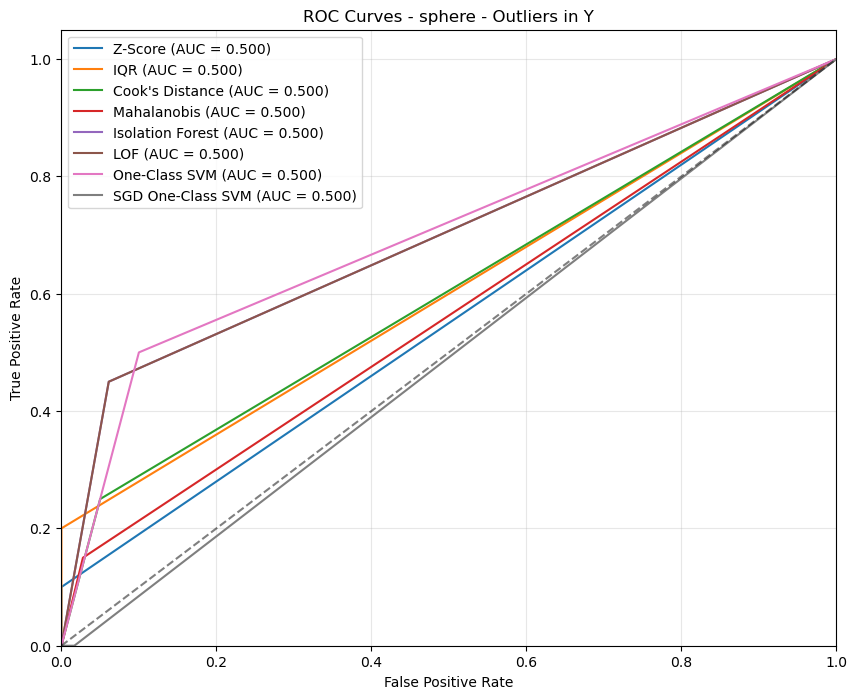


Benchmark: ROSENBROCK (dimension 2)

🎯 Mode d'injection: X
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Leverage: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


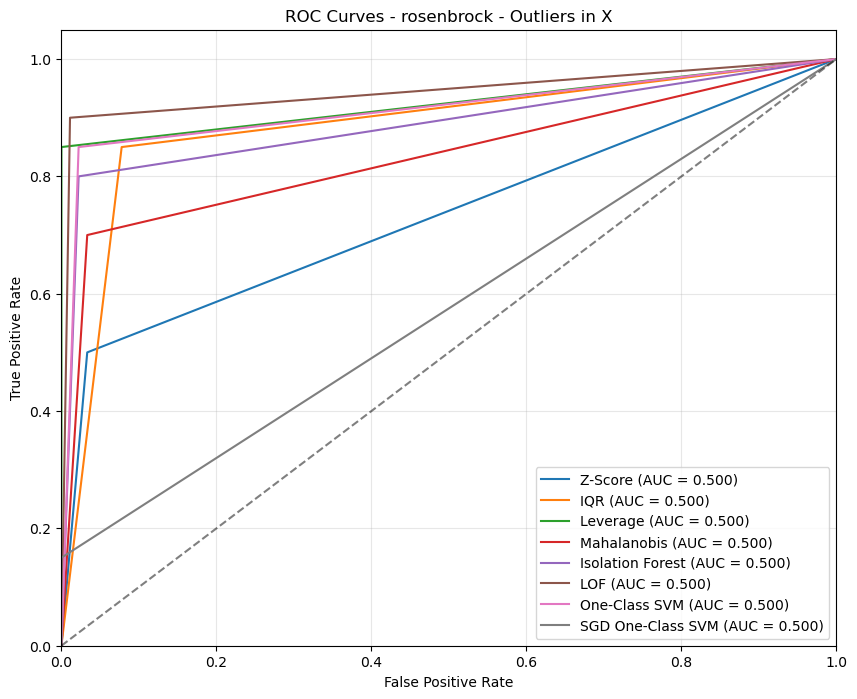


🎯 Mode d'injection: Y
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Cook's Distance: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


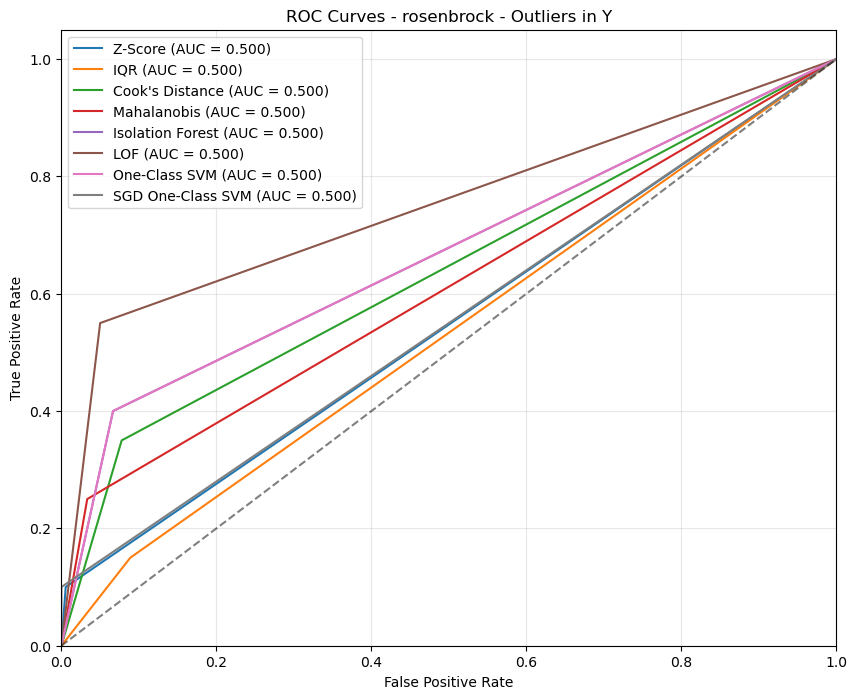


Benchmark: ACKLEY (dimension 2)

🎯 Mode d'injection: X
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Leverage: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


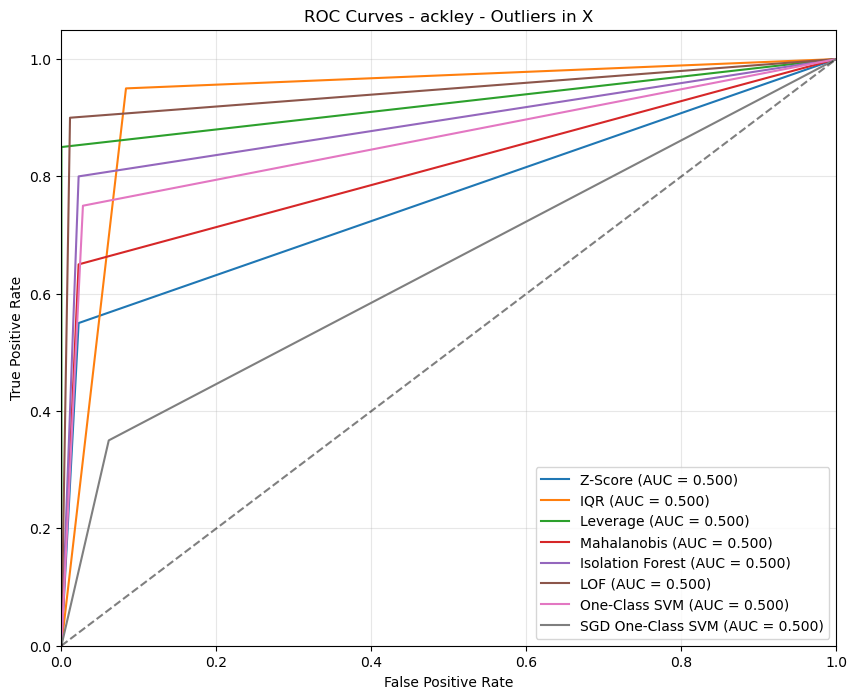


🎯 Mode d'injection: Y
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Cook's Distance: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


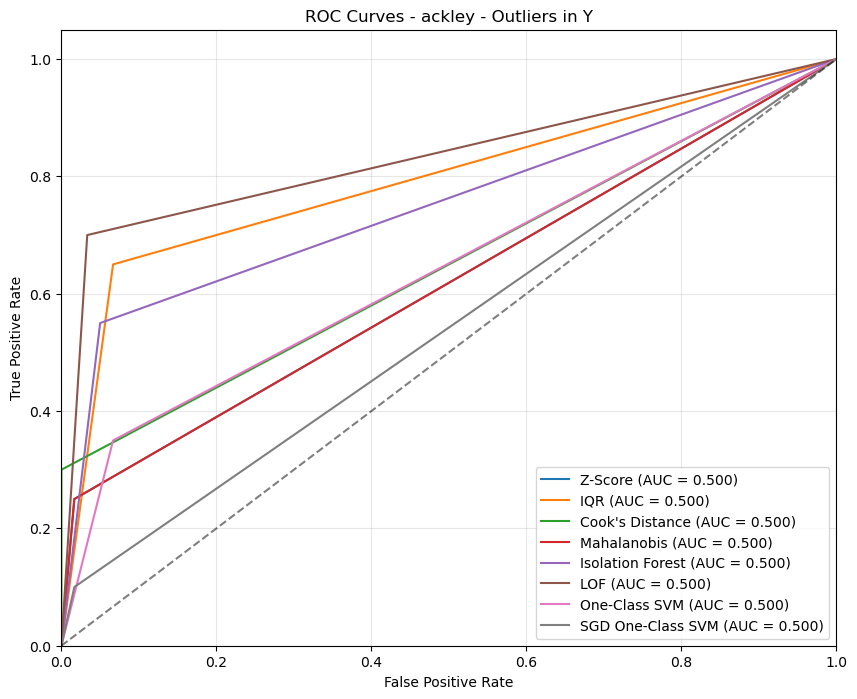


Benchmark: RASTRIGIN (dimension 2)

🎯 Mode d'injection: X
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Leverage: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


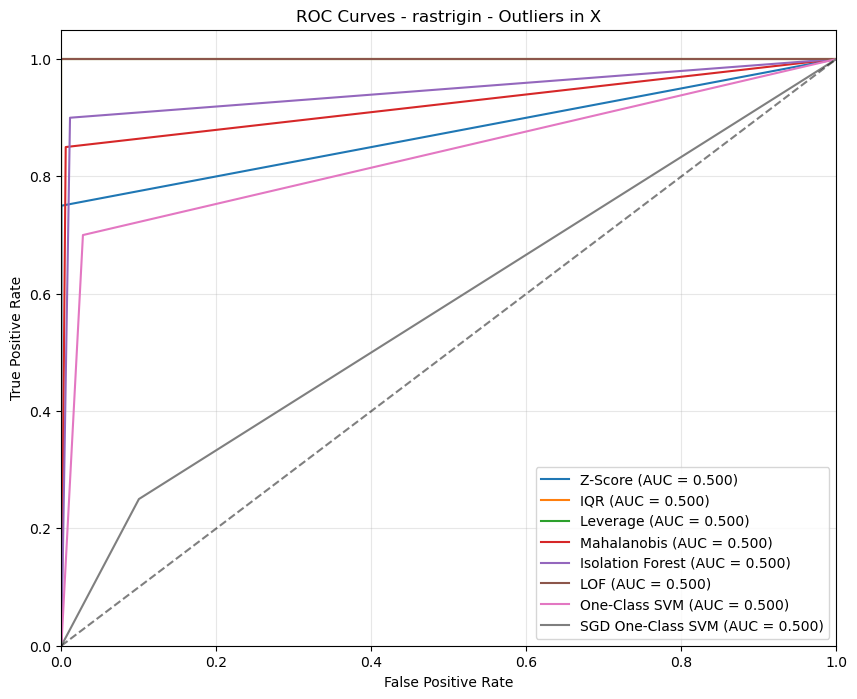


🎯 Mode d'injection: Y
----------------------------------------

Méthodes statistiques:
  Z-Score: Precision=0.000, F1=0.000, AUC=0.500
  IQR: Precision=0.000, F1=0.000, AUC=0.500
  Cook's Distance: Precision=0.000, F1=0.000, AUC=0.500
  Mahalanobis: Precision=0.000, F1=0.000, AUC=0.500

Méthodes d'apprentissage automatique:
  Elliptic Envelope: Erreur - name 'EllipticEnvelope' is not defined
  Isolation Forest: Precision=0.000, F1=0.000, AUC=0.500
  LOF: Precision=0.000, F1=0.000, AUC=0.500
  One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500
  SGD One-Class SVM: Precision=0.000, F1=0.000, AUC=0.500


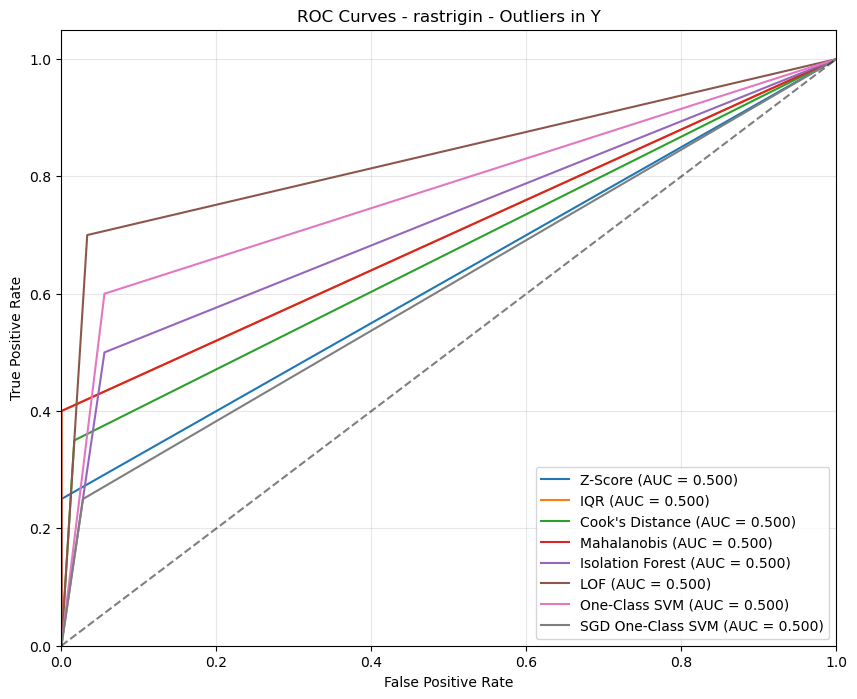


🎯 CRÉATION DES VISUALISATIONS COMPARATIVES


KeyError: 'metrics'

In [43]:
print("🚀 DÉBUT DE L'ANALYSE DE DÉTECTION D'OUTLIERS")
print("=" * 60)

# Lancer les expériences
print("Lancement des expériences sur différents benchmarks...")
results = run_experiments()

print("\n🎯 CRÉATION DES VISUALISATIONS COMPARATIVES")
print("=" * 60)

# Créer les visualisations comparatives
df_results = create_comparison_plots(results)

# Afficher le tableau récapitulatif
print_summary_table(df_results)

print("\n✅ ANALYSE TERMINÉE!")
print("=" * 60)

# Afficher quelques insights
print("\n📊 INSIGHTS PRINCIPAUX:")
print("-" * 30)

# Meilleure méthode globalement
best_method_auc = df_results.groupby('Method')['ROC-AUC'].mean().idxmax()
best_auc_score = df_results.groupby('Method')['ROC-AUC'].mean().max()
print(f"• Meilleure méthode (ROC-AUC): {best_method_auc} ({best_auc_score:.3f})")

# Méthode la plus stable
stability = df_results.groupby('Method')['ROC-AUC'].std()
most_stable = stability.idxmin()
stability_score = stability.min()
print(f"• Méthode la plus stable: {most_stable} (σ={stability_score:.3f})")

# Benchmark le plus difficile
benchmark_difficulty = df_results.groupby('Benchmark')['ROC-AUC'].mean()
hardest_benchmark = benchmark_difficulty.idxmin()
hardest_score = benchmark_difficulty.min()
print(f"• Benchmark le plus difficile: {hardest_benchmark} (AUC moyen={hardest_score:.3f})")

# Benchmark le plus facile
easiest_benchmark = benchmark_difficulty.idxmax()
easiest_score = benchmark_difficulty.max()
print(f"• Benchmark le plus facile: {easiest_benchmark} (AUC moyen={easiest_score:.3f})")

In [ ]:
def detailed_analysis_by_benchmark(all_results):
    """Analyse détaillée par benchmark"""
    print("\n" + "="*80)
    print("ANALYSE DÉTAILLÉE PAR BENCHMARK")
    print("="*80)
    
    for benchmark_name, benchmark_results in all_results.items():
        print(f"\n📋 {benchmark_name.upper()}")
        print("-" * 40)
        
        # Classer les méthodes pour ce benchmark
        methods_performance = []
        for method_name, method_data in benchmark_results.items():
            methods_performance.append({
                'method': method_name,
                'auc': method_data['metrics']['roc_auc'],
                'precision': method_data['metrics']['precision'],
                'f1': method_data['metrics']['f1_score']
            })
        
        # Trier par AUC
        methods_performance.sort(key=lambda x: x['auc'], reverse=True)
        
        print("Classement par ROC-AUC:")
        for i, perf in enumerate(methods_performance, 1):
            print(f"  {i:2d}. {perf['method']:20s}: AUC={perf['auc']:.3f}, "
                  f"Prec={perf['precision']:.3f}, F1={perf['f1']:.3f}")

def export_results_to_csv(df_results, filename="outlier_detection_results.csv"):
    """Exporte les résultats vers un fichier CSV"""
    df_results.to_csv(filename, index=False)
    print(f"\n💾 Résultats exportés vers {filename}")

def plot_method_comparison_radar(df_results):
    """Crée un graphique radar pour comparer les méthodes"""
    from math import pi
    
    # Calculer les moyennes par méthode
    method_means = df_results.groupby('Method')[['Precision', 'F1-Score', 'ROC-AUC']].mean()
    
    # Sélectionner les 6 meilleures méthodes par AUC moyen
    top_methods = method_means.sort_values('ROC-AUC', ascending=False).head(6)
    
    # Paramètres du graphique radar
    categories = ['Precision', 'F1-Score', 'ROC-AUC']
    N = len(categories)
    
    # Calculer les angles
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Compléter le cercle
    
    # Créer le graphique
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Tracer chaque méthode
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_methods)))
    
    for i, (method, values) in enumerate(top_methods.iterrows()):
        values_list = values.tolist()
        values_list += values_list[:1]  # Compléter le cercle
        
        ax.plot(angles, values_list, 'o-', linewidth=2, label=method, color=colors[i])
        ax.fill(angles, values_list, alpha=0.25, color=colors[i])
    
    # Personnaliser le graphique
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
    ax.grid(True)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title('Comparaison radar des top 6 méthodes\n(moyennes sur tous les benchmarks)', 
              size=14, pad=20)
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_outlier_types(all_results):
    """Analyse les types d'outliers détectés par chaque méthode"""
    print("\n" + "="*80)
    print("ANALYSE DES TYPES D'OUTLIERS DÉTECTÉS")
    print("="*80)
    
    for benchmark_name, benchmark_results in all_results.items():
        print(f"\n📊 {benchmark_name.upper()}")
        print("-" * 40)
        
        # Analyser les concordances entre méthodes
        method_predictions = {}
        for method_name, method_data in benchmark_results.items():
            method_predictions[method_name] = method_data['y_pred']
        
        if len(method_predictions) >= 2:
            # Calculer la matrice de corrélation des prédictions
            pred_df = pd.DataFrame(method_predictions)
            correlation_matrix = pred_df.corr()
            
            print("Corrélations entre les prédictions des méthodes:")
            print(correlation_matrix.round(3))
            
            # Identifier les outliers détectés par plusieurs méthodes
            pred_sum = pred_df.sum(axis=1)
            consensus_outliers = pred_sum[pred_sum >= len(method_predictions) * 0.5]
            
            print(f"\nOutliers détectés par la majorité des méthodes: {len(consensus_outliers)} points")

In [ ]:
def advanced_analysis_example():
    """Exemple d'analyse avancée avec paramètres personnalisés"""
    print("\n🔬 ANALYSE AVANCÉE AVEC PARAMÈTRES PERSONNALISÉS")
    print("=" * 60)
    
    # Test avec différents niveaux de contamination
    contamination_levels = [0.05, 0.10, 0.15, 0.20]
    benchmark = Benchmark("sphere", 3)
    ml_detector = MLOutlierDetection()
    
    print("Test de sensibilité au taux de contamination (Isolation Forest sur Sphere):")
    
    results_contamination = {}
    
    for contamination in contamination_levels:
        # Générer les données
        X = benchmark.sample_lhs(200)
        Y = benchmark.evaluate(X)
        n_outliers = int(200 * contamination)
        
        # Injecter des outliers
        X_outliers, Y_outliers, true_outlier_idx = benchmark.inject_outliers(
            X, Y, n_outliers=n_outliers, mode="both"
        )
        
        # Vérité terrain
        y_true = np.zeros(200, dtype=bool)
        y_true[true_outlier_idx] = True
        
        # Détection
        y_pred = ml_detector.isolation_forest(X_outliers, Y_outliers, contamination=contamination)
        metrics = evaluate_outlier_detection(y_true, y_pred)
        
        results_contamination[contamination] = metrics
        print(f"  Contamination {contamination:.0%}: AUC={metrics['roc_auc']:.3f}, "
              f"F1={metrics['f1_score']:.3f}, Prec={metrics['precision']:.3f}")
    
    # Visualiser l'effet de la contamination
    contam_df = pd.DataFrame(results_contamination).T
    contam_df.index.name = 'Contamination'
    
    plt.figure(figsize=(10, 6))
    contam_df.plot(kind='line', marker='o')
    plt.title('Impact du taux de contamination sur les performances (Isolation Forest)')
    plt.xlabel('Taux de contamination')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [ ]:
def run_tests():
    """Exécute des tests de validation du code"""
    print("\n🧪 TESTS DE VALIDATION")
    print("=" * 30)
    
    try:
        # Test 1: Création de benchmark
        benchmark = Benchmark("sphere", 2)
        print("✅ Test 1: Création de benchmark - OK")
        
        # Test 2: Génération de données
        X = benchmark.sample_lhs(50)
        Y = benchmark.evaluate(X)
        assert X.shape == (50, 2)
        assert Y.shape[0] == 50
        print("✅ Test 2: Génération de données - OK")
        
        # Test 3: Injection d'outliers
        X_out, Y_out, idx = benchmark.inject_outliers(X, Y, n_outliers=5)
        assert len(idx) == 5
        print("✅ Test 3: Injection d'outliers - OK")
        
        # Test 4: Détection statistique
        stat_detector = StatisticalOutlierDetection()
        outliers = stat_detector.z_score_outliers(X_out, Y_out)
        assert len(outliers) == 50
        print("✅ Test 4: Détection statistique - OK")
        
        # Test 5: Détection ML
        ml_detector = MLOutlierDetection()
        outliers = ml_detector.isolation_forest(X_out, Y_out)
        assert len(outliers) == 50
        print("✅ Test 5: Détection ML - OK")
        
        print("\n🎉 Tous les tests sont passés avec succès!")
        
    except Exception as e:
        print(f"❌ Erreur dans les tests: {e}")

In [ ]:
def main():
    """Fonction principale avec toutes les analyses améliorées"""
    
    # Tests de validation
    run_tests()
    
    # Analyse principale
    print("🚀 DÉBUT DE L'ANALYSE COMPLÈTE DE DÉTECTION D'OUTLIERS")
    print("=" * 60)
    
    # Lancer les expériences principales
    results = run_experiments()
    
    # Analyses et visualisations
    print("\n🎯 CRÉATION DES VISUALISATIONS COMPARATIVES")
    print("=" * 60)
    df_results = create_comparison_plots(results)
    
    # Analyses détaillées
    print_summary_table(df_results)
    analyze_method_effectiveness_by_outlier_type(df_results)
    detailed_analysis_by_benchmark_and_mode(results)
    create_method_specialization_analysis(df_results)
    
    # Analyses supplémentaires
    plot_method_comparison_radar(df_results)
    plot_performance_evolution(results)
    
    # Export des résultats détaillés
    export_detailed_results_to_csv(df_results, results)
    
    print("\n✅ ANALYSE COMPLÈTE TERMINÉE!")
    print("=" * 60)
    
    # Insights finaux améliorés
    print("\n📊 INSIGHTS PRINCIPAUX:")
    print("-" * 40)
    
    # Analyse par mode d'injection
    injection_modes = df_results['Injection_Mode'].unique()
    for mode in injection_modes:
        df_mode = df_results[df_results['Injection_Mode'] == mode]
        best_method = df_mode.groupby('Method')['ROC-AUC'].mean().idxmax()
        best_score = df_mode.groupby('Method')['ROC-AUC'].mean().max()
        print(f"• Meilleure méthode pour outliers en {mode.upper()}: {best_method} ({best_score:.3f})")
    
    # Méthode la plus robuste globalement
    method_variances = df_results.groupby('Method')['ROC-AUC'].std()
    most_stable = method_variances.idxmin()
    stability_score = method_variances.min()
    print(f"• Méthode la plus robuste: {most_stable} (σ={stability_score:.3f})")
    
    # Benchmark le plus challenging
    benchmark_difficulty = df_results.groupby('Benchmark')['ROC-AUC'].mean()
    hardest_benchmark = benchmark_difficulty.idxmin()
    hardest_score = benchmark_difficulty.min()
    print(f"• Benchmark le plus difficile: {hardest_benchmark} (AUC moyen={hardest_score:.3f})")
    
    return results, df_results

In [ ]:
results, df_results = main()